# Анализ  АB-теста.

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил **с 2022-04-04 по 2022-04-10** включительно. Для эксперимента были задействованы **2 (тестовая)** и **1 (контрольная)** группы.

**Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR**. 

Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали: 
* t-тест, 
* Пуассоновский бутстреп, 
* тест Манна-Уитни, 
* t-тест на сглаженном ctr (α=5), а также 
* t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. Почему тесты сработали так как сработали? Опишите потенциальную ситуацию, когда такое изменение могло произойти.
3. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats
import numpy as np

## Загружаем данные

In [2]:
# Загружаем датасет
# Подключаемся к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220420'
}
# Запрос к БД
# Данные о количестве пользователей, просмотров, лайков и сообщений в приложении за неделю
q = '''
    SELECT 
        exp_group, user_id, 
        countIf(action='like') as likes,
        countIf(action='view') as views,
        countIf(action='like')/countIf(action='view') as ctr
    FROM
        simulator_20220420.feed_actions
    WHERE 
        (toDate(time) BETWEEN '2022-04-04' AND '2022-04-10') 
        AND (exp_group IN (1, 2))
    GROUP BY
        user_id, exp_group
'''
# Сохраним результат запроса в pandas df
df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


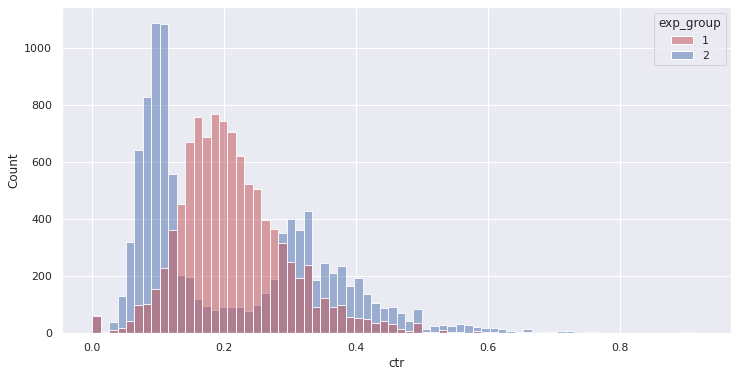

In [4]:
# Сразу посмотрим на распределение CTR в 2-х группах

# Зададим параметры графиков
sns.set(rc={"figure.figsize":(12, 6)}) 
plt.tight_layout()

ax = sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'b'])

In [5]:
# Статистики по контрольной 1-й группе
df[df['exp_group']==1].ctr.describe()

count    10079.000000
mean         0.215605
std          0.084160
min          0.000000
25%          0.160097
50%          0.203125
75%          0.257654
max          0.722222
Name: ctr, dtype: float64

In [6]:
# Статистики по тестовой 2-й группе
df[df['exp_group']==2].ctr.describe()

count    9952.000000
mean        0.214419
std         0.144180
min         0.000000
25%         0.095238
50%         0.142857
75%         0.325000
max         0.923077
Name: ctr, dtype: float64

И среднее и медиана CTR в контрольной группе выше, чем в тестовой. Визуально все выглядит так же. Интересно, что распределение значений в контрольной группе похоже на нормальное, а в тестовой - отличается [от нормального].  
Кажется, гипотеза о том, что новый алгоритм во 2-й группе приведет к увеличению CTR не подтверждается. Проверим это статистическими тестами. 

## 1. t-тест Стьюдента

Проверяем **гипотезу, что новый алгоритм во 2-й группе приведет к увеличению CTR**.
* **H0** - средние значения CTR в контрольной и экспериментальной группaх равны.
* **H1** - средние значения CTR в тестовой группе выше, чем в контрольной.

Уровень значимости альфа возьмем равным 5%.

In [7]:
# Параметрический t-test
stats.ttest_ind(df[df['exp_group']==2].ctr, 
                df[df['exp_group']==1].ctr, 
                equal_var=False,
                alternative='greater')

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.7609688434562533)

**Результат**: p-value >> 0.05, следовательно мы **не можем принять альтернативную гипотезу(H1)** о том, что средние значения CTR в тестовой группе выше, чем в контрольной.

In [8]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
stats.ttest_ind(df[df['exp_group']==2].ctr, 
                df[df['exp_group']==1].ctr, 
                equal_var=False,
                alternative='less')

# Гипотеза, что среднее значение CTR контрольной группы (1) больше, чем CTR тестовой (2) также не подтверждается.

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.23903115654374674)

## 2. Тест Манна-Уитни

In [9]:
# Непараметрический U-критерий Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr, 
                   alternative='greater')

MannwhitneyuResult(statistic=43704947.5, pvalue=1.0)

**Результат**: p-value >>> 0.05, следовательно мы **не можем принять альтернативную гипотезу(H1)** о том, что средние значения CTR в тестовой группе выше, чем в контрольной.

In [10]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr, 
                   alternative='less')

# p-value <<< 0.05, следовательно можем принять гипотезу, что среднее значение CTR контрольной группы (1) больше, чем CTR тестовой (2). 
# Т.е. новый алгоритм во 2 группе привел к снижению CTR.

MannwhitneyuResult(statistic=43704947.5, pvalue=3.0188242308889518e-56)

## 3. Сглаженный CTR

Применим "сглаживание" CTR для более корректной оценки CTR пользователей с низким количеством просмотров.

In [11]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha=5):
    '''
    функция get_smoothed_ctr преобразует пользовательский CTR в сглаженный CTR
    
    Параметры:
    user_likes - лайки пользователя
    user_views - просмотры пользователя
    global_ctr - общий CTR по группе
    alpha - коэффициент сглаживания

    Функция возвращает: 
    smoothed_ctr - значение сглаженного CTR
    '''
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [12]:
# Глобальный CTR контрольной 1-й группы
global_ctr_1 = df[df['exp_group'] == 1].likes.sum()/df[df['exp_group'] == 1].views.sum()
print('Глобальный CTR 1 группы:', global_ctr_1)
# Глобальный CTR тестовой 2-й группы
global_ctr_2 = df[df['exp_group'] == 2].likes.sum()/df[df['exp_group'] == 2].views.sum()
print('Глобальный CTR 2 группы:', global_ctr_2)

Глобальный CTR 1 группы: 0.20802680490126244
Глобальный CTR 2 группы: 0.1980601844115994


In [13]:
# Добавим столбец smoothed_ctr в df
df.loc[df['exp_group'] == 1, 'smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)
df.loc[df['exp_group'] == 2, 'smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)

In [14]:
# Мы избавились от нулевых ctr
df.sort_values('views')

,exp_group,user_id,likes,views,ctr,smoothed_ctr
16688,2,141164,0,1,0.000000,0.165050
14864,2,17749,0,1,0.000000,0.165050
19169,2,21921,0,1,0.000000,0.165050
16367,1,6384,0,2,0.000000,0.148591
7421,1,109414,0,2,0.000000,0.148591
...,...,...,...,...,...,...
3375,2,132375,31,303,0.102310,0.103865
17240,1,24486,47,304,0.154605,0.155470
10063,1,111930,38,311,0.122186,0.123545
15937,2,130522,26,320,0.081250,0.083047


<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

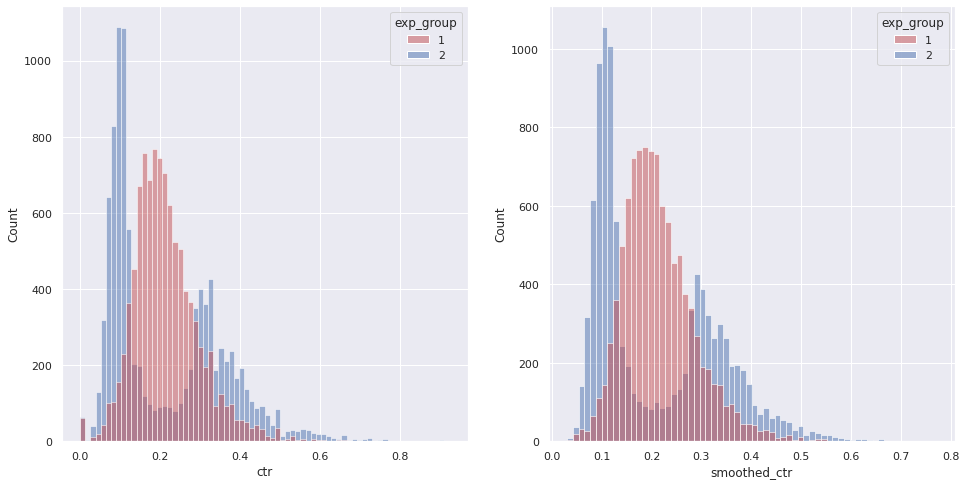

In [15]:
# Посмотрим, сгладились ли значения CTR
f, axs = plt.subplots(1,2, figsize=(16,8))
sns.histplot(df, x='ctr', hue='exp_group', palette=['r','b'], ax=axs[0])
sns.histplot(df, x='smoothed_ctr', hue='exp_group', palette=['r','b'], ax=axs[1])

### 3.1. t-тест Стьюдента на сглаженном CTR

Проверяем **гипотезу, что новый алгоритм во 2-й группе приведет к увеличению CTR**.
* **H0** - средние значения *сглаженного CTR* в контрольной и экспериментальной группaх равны.
* **H1** - средние значения *сглаженного CTR* в тестовой группе выше, чем в контрольной.

Уровень значимости альфа возьмем равным 5%.

In [16]:
# Параметрический t-test
stats.ttest_ind(df[df['exp_group']==2].smoothed_ctr, 
                df[df['exp_group']==1].smoothed_ctr, 
                equal_var=False,
                alternative='greater')

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.9888115092220721)

**Результат**: p-value >>> 0.05, следовательно мы **не можем принять альтернативную гипотезу(H1)** о том, что средние значения сглаженного CTR в тестовой группе выше, чем в контрольной.

In [17]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
stats.ttest_ind(df[df['exp_group']==2].smoothed_ctr, 
                df[df['exp_group']==1].smoothed_ctr, 
                equal_var=False,
                alternative='less')

# p-value > 0.05, следовательно НЕ можем принять гипотезу, что среднее значение CTR контрольной группы (1) больше, чем CTR тестовой (2). 

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.01118849077792795)

## 4. Бутстреп

Будем многократно (например, 2000 раз) считать общегрупповой CTR по псевдовыборкам из тестовой (2) и контрольной (1) групп.

In [18]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    '''
    функция bootstrap многократно рассчитывает глобальный CTR по псевдовыборкам из каждой группы
    
    Параметры:
    likes1 - количество лайков пользователей из 1-й группы
    likes2 - количество лайков пользователей из 2-й группы
    views1 - количество просмотров пользователей из 1-й группы
    views2 - количество просмотров пользователей из 2-й группы

    Функция возвращает: 
    globalCTR1 - общий CTR по 1-й группе 
    globalCTR2 - общий CTR по 2-й группе 
    '''
    # Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку» для 1-й и 2-й группы
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    # Считаем глобальный CTR для каждой группы
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [19]:
# Лайки и просмотры для 1-й (контрольной) группы
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
# Лайки и просмотры для 2-й (тестовой) группы
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [20]:
# Глобальный CTR для 1-й и 2-й групп
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

In [21]:
# Статистики по контрольной 1-й группе
print('Среднее по 1 группе:', round(ctr1.mean(), 6))
print('Медиана по 1 группе:', round(np.median(ctr1), 6))

Среднее по 1 группе: 0.208034
Медиана по 1 группе: 0.208015


In [22]:
# Статистики по тестовой 2-й группе
print('Среднее по 2 группе:', round(ctr2.mean(), 6))
print('Медиана по 2 группе:', round(np.median(ctr2), 6))

Среднее по 2 группе: 0.198022
Медиана по 2 группе: 0.19802


<AxesSubplot:ylabel='Count'>

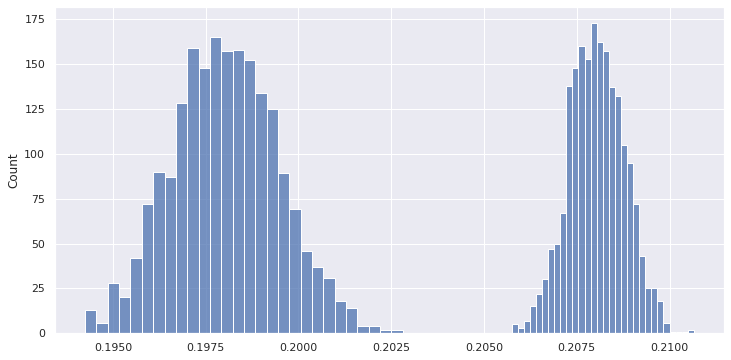

In [23]:
# Визуализируем глобальные CTR-ы 
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

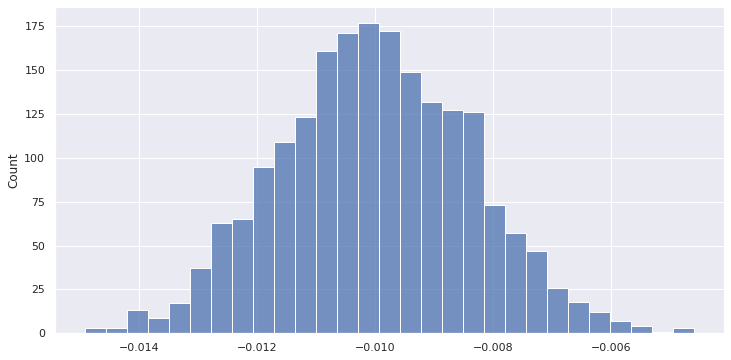

In [24]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1)

Разница отрицательная. Более того, **ВСЕ** значения в 1 группе больше, чем во 2-й. Соответственно, можем утверждать, что новый алгоритм (группа 2) не приведет к увеличению CTR пользователей.  
Проверим тестами.

### 4.1. t-тест Стьюдента

Проверяем **гипотезу, что новый алгоритм во 2-й группе приведет к увеличению CTR**.
* **H0** - средние значения CTR в контрольной и экспериментальной группaх равны.
* **H1** - средние значения CTR в тестовой группе выше, чем в контрольной.

Уровень значимости альфа возьмем равным 5%.

In [25]:
# Параметрический t-test
stats.ttest_ind(ctr2, ctr1, equal_var=False, alternative='greater')

Ttest_indResult(statistic=-276.233701305466, pvalue=1.0)

Результат: p-value >>> 0.05, следовательно мы не можем принять альтернативную гипотезу(H1) о том, что средние значения сглаженного CTR в тестовой группе выше, чем в контрольной.

In [26]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
stats.ttest_ind(ctr2, ctr1, equal_var=False, alternative='less')

# p-value <<< 0.05, следовательно можем принять гипотезу, что среднее значение CTR контрольной группы (1) больше, чем CTR тестовой (2). 
# Т.е. новый алгоритм во 2 группе привел к снижению CTR.

Ttest_indResult(statistic=-276.233701305466, pvalue=0.0)

### 4.2. Тест Манна-Уитни

In [27]:
# Непараметрический U-критерий Манна-Уитни
stats.mannwhitneyu(ctr2, ctr1, alternative='greater')

MannwhitneyuResult(statistic=0.0, pvalue=1.0)

**Результат**: p-value >>>> 0.05, следовательно мы **не можем принять альтернативную гипотезу(H1)** о том, что средние значения CTR в тестовой группе выше, чем в контрольной.

In [28]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
stats.mannwhitneyu(ctr2, ctr1, alternative='less')

# p-value <<< 0.05, следовательно можем принять гипотезу, что среднее значение CTR контрольной группы (1) больше, чем CTR тестовой (2). 
# Т.е. новый алгоритм во 2 группе привел к снижению CTR.

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

## 5. Бакетное преобразование

Разобъем пользователей на n=50 бакетов. И для каждого бакета рассчитаем статистику - среднее.

In [29]:
# Запрос для разбиения групп на бакеты
q = """
    SELECT 
        exp_group, bucket,
        sum(likes)/sum(views) as bucket_ctr
    FROM 
        (SELECT 
            exp_group,
            xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM 
            simulator_20220420.feed_actions
        WHERE 
            (toDate(time) BETWEEN '2022-04-04' AND '2022-04-10')
            AND (exp_group IN (1, 2))
        GROUP BY 
            exp_group, bucket, user_id)
    GROUP BY 
        exp_group, bucket
"""
# Сохраним результат запроса в pandas df
df_b = pandahouse.read_clickhouse(q, connection=connection)

In [30]:
df_b.head() 

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


### 5.1. t-тест Стьюдента

Проверяем **гипотезу, что новый алгоритм во 2-й группе приведет к увеличению CTR**.
* **H0** - средние значения CTR в контрольной и экспериментальной группaх равны.
* **H1** - средние значения CTR в тестовой группе выше, чем в контрольной.

Уровень значимости альфа возьмем равным 5%.

In [31]:
# Параметрический t-test
stats.ttest_ind(df_b[df_b['exp_group']==2].bucket_ctr, 
                df_b[df_b['exp_group']==1].bucket_ctr, 
                equal_var=False, 
                alternative='greater')

Ttest_indResult(statistic=-5.668234732053979, pvalue=0.9999998277202418)

Результат: p-value >> 0.05, следовательно мы **не можем принять альтернативную гипотезу(H1)** о том, что средние значения сглаженного CTR в тестовой группе выше, чем в контрольной.

In [32]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
stats.ttest_ind(df_b[df_b['exp_group']==2].bucket_ctr, 
                df_b[df_b['exp_group']==1].bucket_ctr, 
                equal_var=False, 
                alternative='less')

# p-value << 0.05, следовательно можем принять гипотезу, что среднее значение CTR контрольной группы (1) больше, чем CTR тестовой (2). 
# Т.е. новый алгоритм во 2 группе привел к снижению CTR.

Ttest_indResult(statistic=-5.668234732053979, pvalue=1.7227975824972953e-07)

### 5.2. Тест Манна-Уитни

In [33]:
# Непараметрический U-критерий Манна-Уитни
stats.mannwhitneyu(df_b[df_b['exp_group']==2].bucket_ctr, 
                   df_b[df_b['exp_group']==1].bucket_ctr, 
                   alternative='greater')

MannwhitneyuResult(statistic=505.0, pvalue=0.9999998621494246)

**Результат**: p-value >>> 0.05, следовательно мы **не можем принять альтернативную гипотезу(H1)** о том, что средние значения CTR в тестовой группе выше, чем в контрольной.

In [34]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
stats.mannwhitneyu(df_b[df_b['exp_group']==2].bucket_ctr, 
                   df_b[df_b['exp_group']==1].bucket_ctr, 
                   alternative='less')

# p-value << 0.05, следовательно можем принять гипотезу, что среднее значение CTR контрольной группы (1) больше, чем CTR тестовой (2). 
# Т.е. новый алгоритм во 2 группе привел к снижению CTR.

MannwhitneyuResult(statistic=505.0, pvalue=1.429981968246323e-07)

## 6. Выводы

Мы провели несколько тестов:
* t-тест, 
* тест Манна-Уитни, 
* Пуассоновский бутстреп
* t-тест на сглаженном ctr (α=5)
* t-тест и тест Манна-Уитни поверх бакетного преобразования.  

Результаты всех тестов показали, что с 2022-04-04 по 2022-04-10 средний CTR в тестовой группе (2) не выше среднего CTR в контрольной группе (1), а даже наоборот. То же самое подтвердилось и визуально.

Соответственно, **можем отвергнуть гипотезу о том, что новый алгоритм во 2-й группе приведет к увеличению CTR**.

**Почему так произошло?**

Самый очевидный вариант - что-то не так с алгоритмом, новый алгоритм стал выдавать менее интересные посты пользователям. Нужно обращаться ML-щикам.

Возможно, в экспериментальной 2 группе существенно выросло количество просмотров или количество показываемых постов. Немного исследуем данные.

### 6.1. Как изменились просмотры в группах?

<AxesSubplot:xlabel='views', ylabel='Count'>

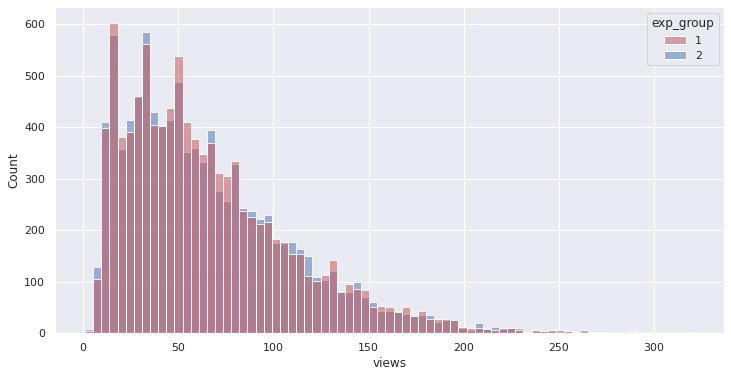

In [46]:
# Гистограмма количества просмотров по группам
sns.histplot(data=df, x='views', hue='exp_group', palette=['r', 'b'])

**Является ли изменение количества просмотров в группах статистически значимым?**

In [43]:
# Проверим критерием Манна-Уитни с уровнем значимости 5%, стало ли в экспериментальной группе больше просмотров, чем в контрольной
# H0 - количество просмотров в группах равно; # H1 - количество просмотров во 2-й группе больше, чем в 1-й

stats.mannwhitneyu(df[df['exp_group']==2].views, 
                   df[df['exp_group']==1].views, 
                   alternative='greater')

# p-value > 0.05. Принимаем нулевую гипотезу, разница в просмотрах статистически незначима.

MannwhitneyuResult(statistic=49994123.5, pvalue=0.651188457751096)

In [45]:
# Проверим критерием Манна-Уитни с уровнем значимости 5% обратное, стало ли в экспериментальной группе меньше просмотров, чем в контрольной
# H0 - количество просмотров в группах равно; # H1 - количество просмотров во 2-й группе меньше, чем в 1-й

stats.mannwhitneyu(df[df['exp_group']==2].views, 
                   df[df['exp_group']==1].views, 
                   alternative='less')

# p-value > 0.05. Принимаем нулевую гипотезу, разница в просмотрах статистически незначима.

MannwhitneyuResult(statistic=49994123.5, pvalue=0.3488124463375471)

### 6.2. Как изменились лайки в группах?

<AxesSubplot:xlabel='likes', ylabel='Count'>

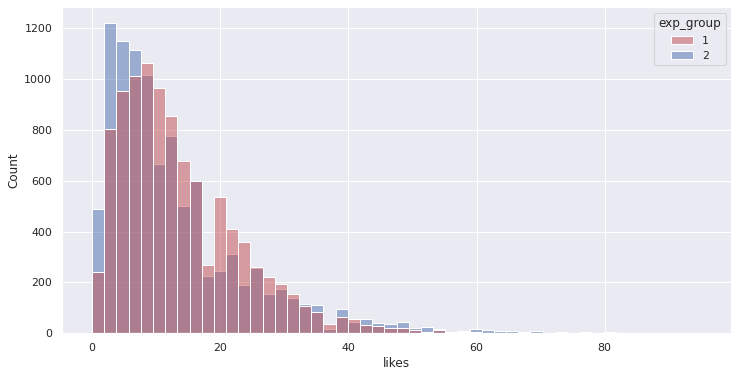

In [52]:
# Гистограмма количества лайков по группам
sns.histplot(data=df, x='likes', hue='exp_group', palette=['r', 'b'], bins=50)

**Является ли изменение количества лайков в группах статистически значимым?**

In [54]:
# Проверим критерием Манна-Уитни с уровнем значимости 5%, стало ли в экспериментальной группе больше лайков, чем в контрольной
# H0 - количество лайков в группах равно; # H1 - количество лайков во 2-й группе больше, чем в 1-й

stats.mannwhitneyu(df[df['exp_group']==2].likes, 
                   df[df['exp_group']==1].likes, 
                   alternative='greater')

# p-value >> 0.05. Принимаем нулевую гипотезу, разница в лайках статистически незначима.

MannwhitneyuResult(statistic=44792538.0, pvalue=1.0)

In [56]:
# Проверим критерием Манна-Уитни с уровнем значимости 5% обратное, стало ли в экспериментальной группе меньше лайков, чем в контрольной
# H0 - количество лайков в группах равно; # H1 - количество лайков во 2-й группе меньше, чем в 1-й

stats.mannwhitneyu(df[df['exp_group']==2].likes, 
                   df[df['exp_group']==1].likes, 
                   alternative='less')

# p-value << 0.05. Принимаем альтернативную гипотезу, количество лайков в 1-й группе больше, чем во 2-й с уровнем значимости 5%.

MannwhitneyuResult(statistic=44792538.0, pvalue=1.4300962888572648e-39)

Исходя из проведенных тестов, мы видим, что разница в  CTR в тестовой и контрольной группах обусловлено только изменением количества лайков пользователями. Значит, **пользователям стали меньше нравится посты, предлагаемые новым алгоритмом**.

### 6.3. Количество показываемых постов в группах

Возможно, количество показываемых постов пользователям в экспериментальной группе просто слишком возросло, что привело к падению CTR.

In [58]:
# Данные о количестве пользователей, постов, просмотров, лайков и сообщений в приложении за неделю
q = '''
    SELECT 
        exp_group, user_id, 
        COUNT(DISTINCT post_id) as posts,
        countIf(action='like') as likes,
        countIf(action='view') as views,
        countIf(action='like')/countIf(action='view') as ctr
    FROM
        simulator_20220420.feed_actions
    WHERE 
        (toDate(time) BETWEEN '2022-04-04' AND '2022-04-10') 
        AND (exp_group IN (1, 2))
    GROUP BY
        user_id, exp_group
'''
# Сохраним результат запроса в pandas df
df_p = pandahouse.read_clickhouse(q, connection=connection)

In [60]:
df_p.head()

,exp_group,user_id,posts,likes,views,ctr
0,1,109963,15,3,15,0.200000
1,1,26117,91,32,141,0.226950
2,1,138232,55,18,73,0.246575
3,1,26295,87,33,122,0.270492
4,1,18392,27,7,32,0.218750


<AxesSubplot:xlabel='posts', ylabel='Count'>

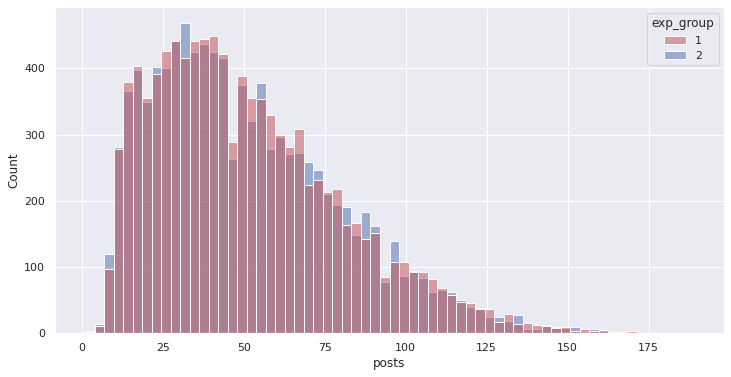

In [61]:
# Гистограмма количества постов по группам
sns.histplot(data=df_p, x='posts', hue='exp_group', palette=['r', 'b'])

**Является ли изменение количества постов в группах статистически значимым?**

In [62]:
# Проверим критерием Манна-Уитни с уровнем значимости 5%, отличается ли количество постов в экспериментальной группе от постов в контрольной
# H0 - количество постов в группах равно; # H1 - количество постов во 2-й группе и в 1-й группе не равно

stats.mannwhitneyu(df[df['exp_group']==2].views, 
                   df[df['exp_group']==1].views, 
                   alternative='two-sided')

# p-value > 0.05. Принимаем нулевую гипотезу, разница в количестве постов статистически незначима.

MannwhitneyuResult(statistic=49994123.5, pvalue=0.6976248926750942)

## 7. Рекомендации

По результатам AB-тестов с 2022-04-04 по 2022-04-10 **гипотеза о том, что новый алгоритм приведет к увеличению CTR была опровергнута**.

Падение CTR вызвано уменьшением (стат. значимым) количества лайков. Т.е. новый алгоритм стал рекомендовать пользователям "не те" посты.

**Не рекомендую раскатывать новый алгоритм на всех новых пользователей**.